### Decision Tree Classifier
#### Build a model that predicts the Drug to be prescribed to the patients on basis of their medical results
##### Step1: Data Gathering

In [1]:
import pandas as pd
path = r"https://raw.githubusercontent.com/sindhura-nk/Datasets/refs/heads/main/drug200.csv"
df = pd.read_csv(path)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
### Step2: Perform the basic data quality checks

In [4]:
df.shape

(200, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
df['Drug'].unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

In [7]:
## Check for duplicated information
df.duplicated().sum()

np.int64(0)

In [ ]:
df=df.drop_duplicates()

In [9]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

### Separate X and Y features
* X: all features except Drug
* Y: Drug

In [12]:
X = df.drop(columns=['Drug'])
Y = df[['Drug']]

In [13]:
X.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [14]:
Y.head()

,Drug
0,DrugY
1,drugC
2,drugC
3,drugX
4,DrugY


### Feature Engineering: Data cleaning, Data preprocessing(Feature Scaling)

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

cat = list(X.select_dtypes(include='object').columns)
con = list(X.select_dtypes(include='number').columns)


num_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore',sparse_output=False)
)

pre = ColumnTransformer([
    ('cat',cat_pipe,cat),
    ('con',num_pipe,con)
]).set_output(transform='pandas')

X_pre = pre.fit_transform(X)
X_pre.head()

,cat__Sex_F,cat__Sex_M,cat__BP_HIGH,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_HIGH,cat__Cholesterol_NORMAL,con__Age,con__Na_to_K
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.291591,1.286522
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.162699,-0.415145
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.162699,-0.828558
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.988614,-1.149963
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.011034,0.271794


## Split the data into training and testing

In [18]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,train_size=0.66,random_state=21)

In [19]:
print(f"xtrain:{xtrain.shape}")
print(f"xtest:{xtest.shape}")
print(f"ytrain:{ytrain.shape}")
print(f"ytest:{ytest.shape}")

xtrain:(132, 9)
xtest:(68, 9)
ytrain:(132, 1)
ytest:(68, 1)


## Model building- decision tree model

In [20]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=3,
    min_samples_split=5
)

model.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5)

In [21]:
model.score(xtrain,ytrain)

1.0

In [22]:
model.score(xtest,ytest)

0.9705882352941176

## Hyperparameter Tuning
criterion='gini',
max_depth=5,
min_samples_leaf=3,
min_samples_split=5


In [23]:
params ={
    'max_depth':[3,4,5,6,7],
    'min_samples_leaf':[1,2,3,4,5,9,11],
    'min_samples_split':[3,5,7,9,10],
    'criterion':['gini','entropy']
}

In [24]:
from sklearn.model_selection import RandomizedSearchCV
base_model = DecisionTreeClassifier()
rscv = RandomizedSearchCV(estimator=base_model,param_distributions=params,cv=3,scoring='f1_macro')
rscv.fit(xtrain,ytrain)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 9,
                                                             11],
                                        'min_samples_split': [3, 5, 7, 9, 10]},
                   scoring='f1_macro')

## Model evaluation

In [25]:
rscv.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 5,
 'criterion': 'entropy'}

In [26]:
rscv.best_score_

np.float64(0.9955510616784631)

In [27]:
best_dtc = rscv.best_estimator_
best_dtc

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       min_samples_split=5)

In [28]:
best_dtc.score(xtrain,ytrain)

1.0

In [29]:
best_dtc.score(xtest,ytest)

0.9705882352941176

## Confusion Matrix and Classification Report

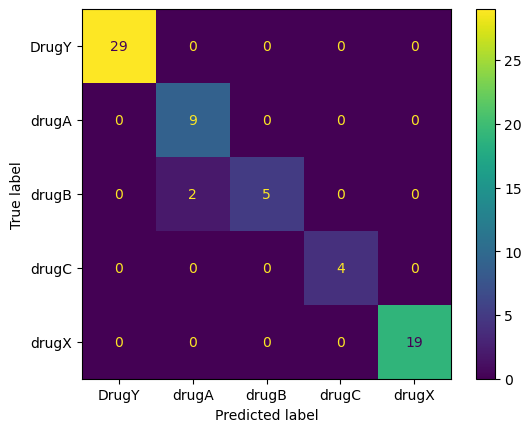

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_dtc,xtest,ytest)

In [31]:
from sklearn.metrics import classification_report
ypreds = model.predict(xtest)
print(classification_report(ytest,ypreds))

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        29
       drugA       0.82      1.00      0.90         9
       drugB       1.00      0.71      0.83         7
       drugC       1.00      1.00      1.00         4
       drugX       1.00      1.00      1.00        19

    accuracy                           0.97        68
   macro avg       0.96      0.94      0.95        68
weighted avg       0.98      0.97      0.97        68



In [32]:

from sklearn.metrics import f1_score
f1 = f1_score(ytest,ypreds,average='macro')
f1

0.9466666666666667

## Plot the decision tree

In [33]:
xtrain.columns

Index(['cat__Sex_F', 'cat__Sex_M', 'cat__BP_HIGH', 'cat__BP_LOW',
       'cat__BP_NORMAL', 'cat__Cholesterol_HIGH', 'cat__Cholesterol_NORMAL',
       'con__Age', 'con__Na_to_K'],
      dtype='object')

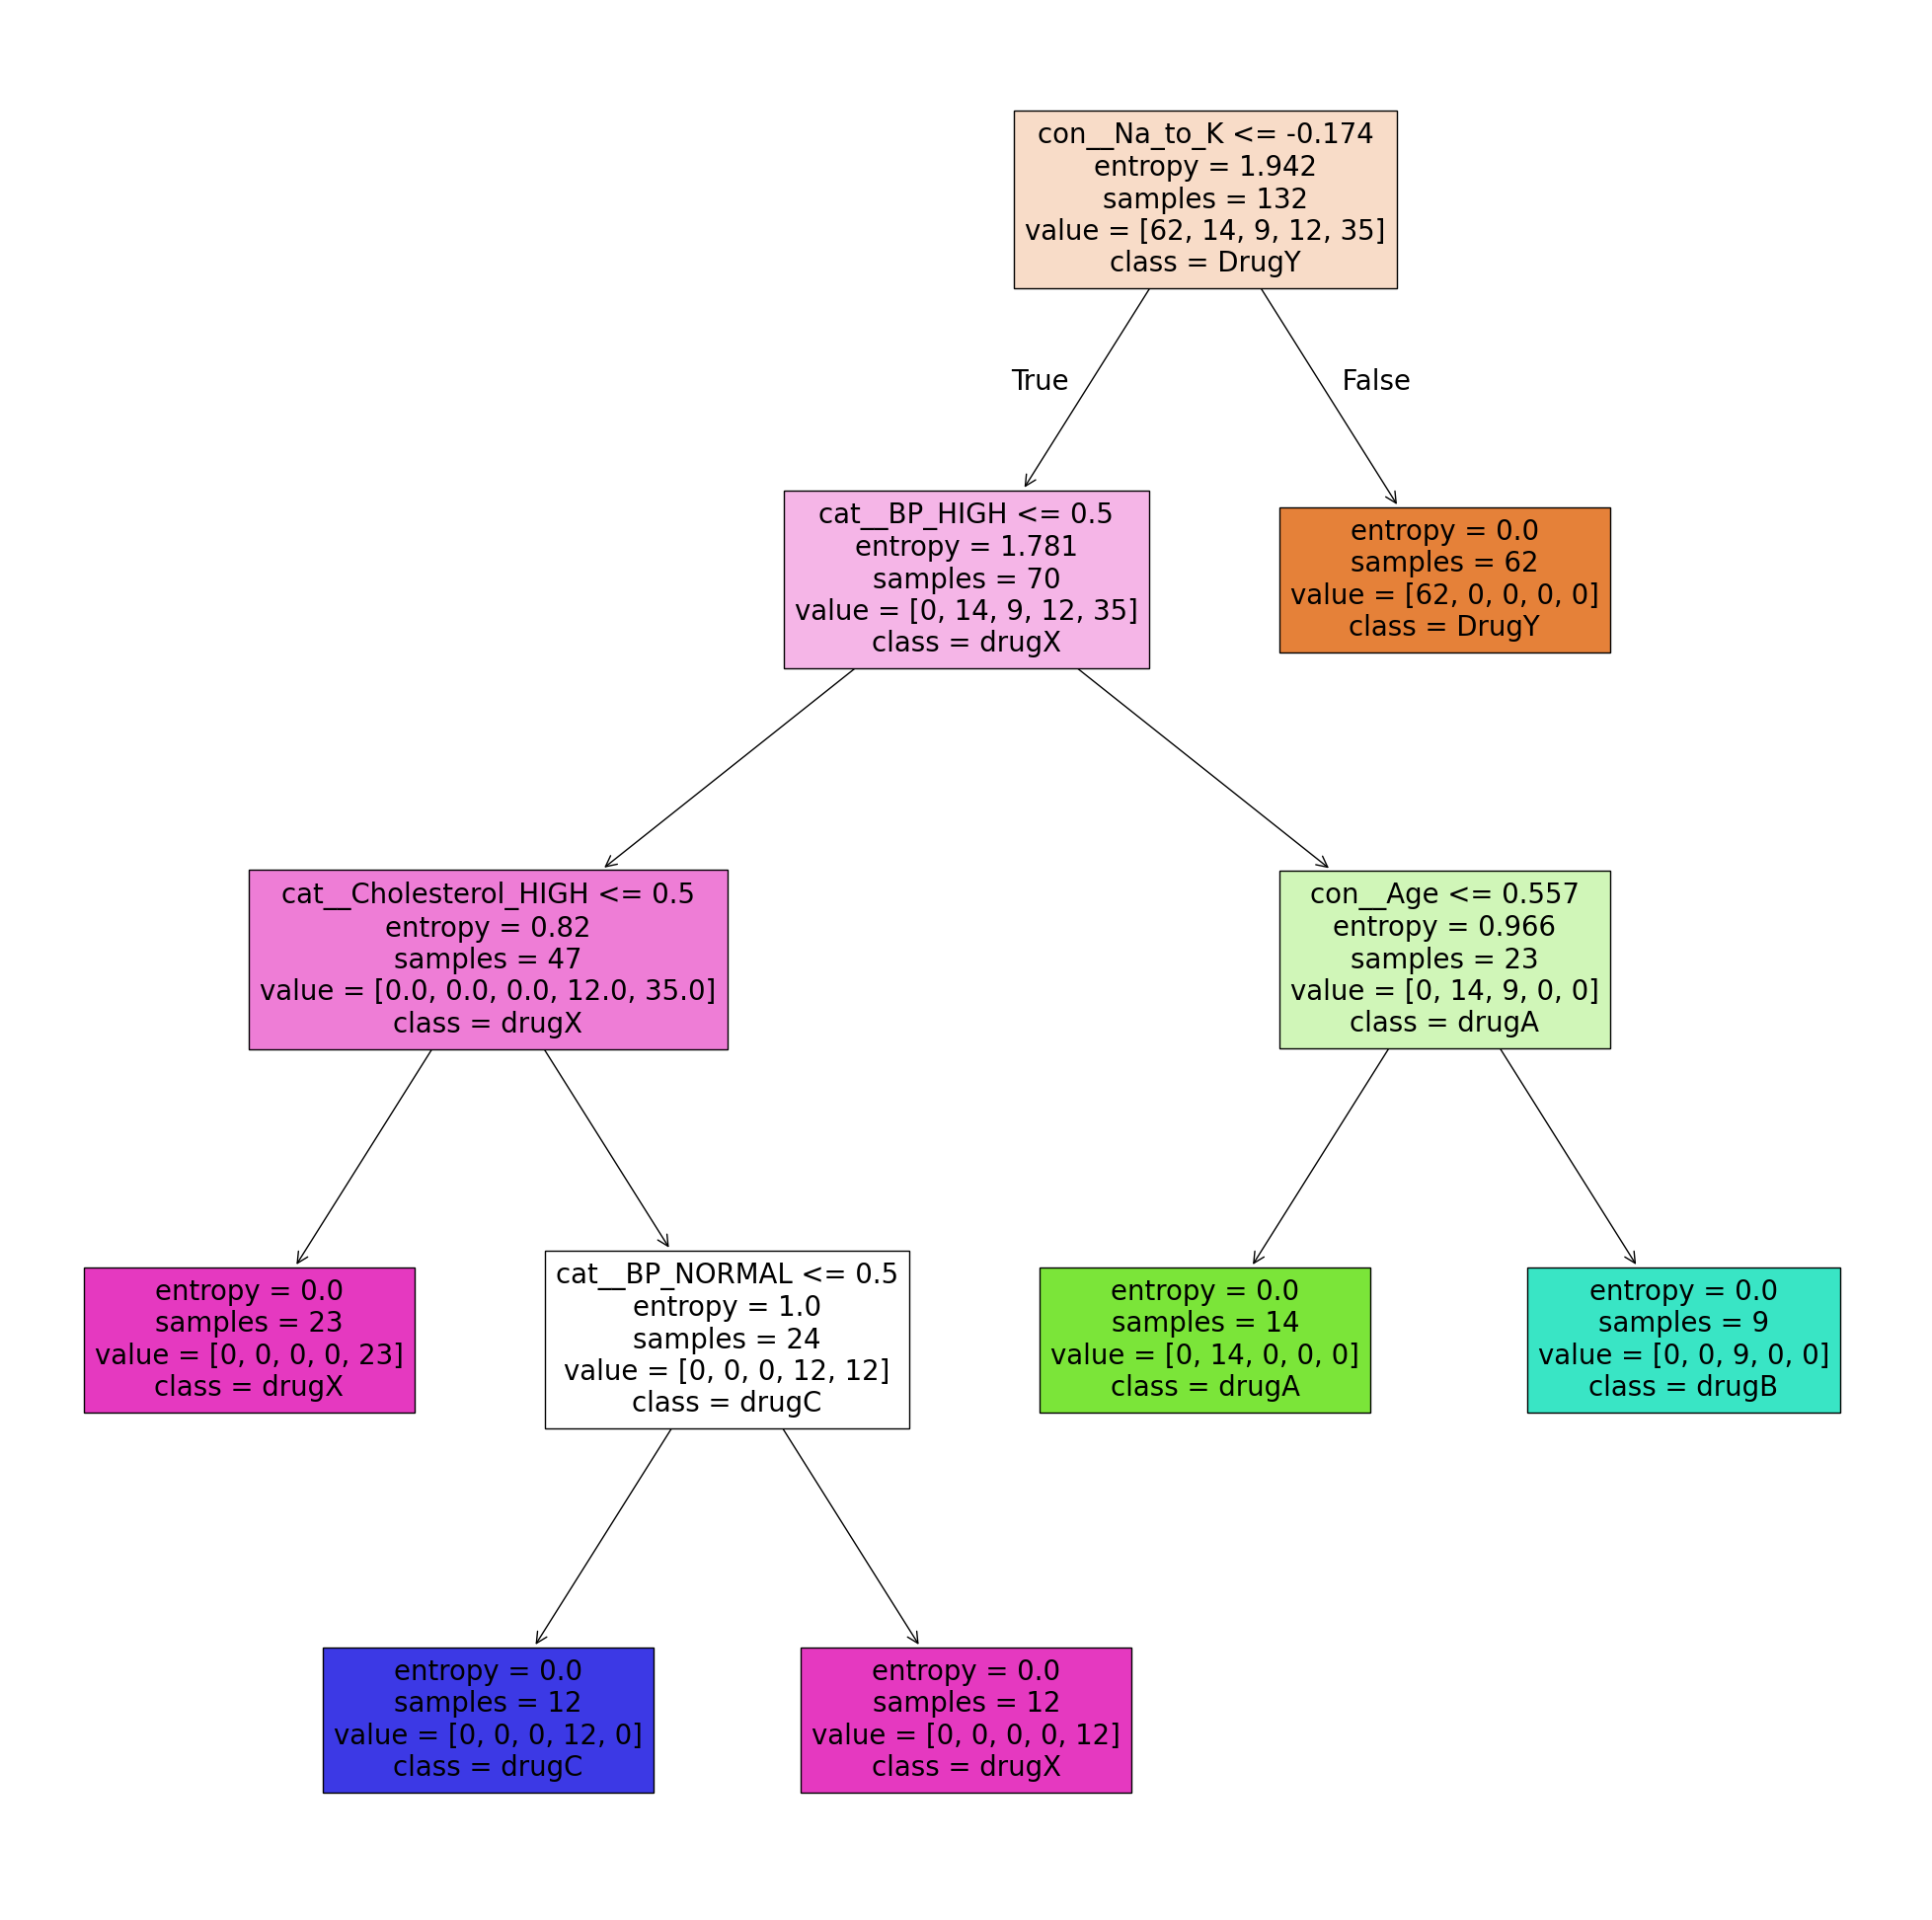

In [34]:
from sklearn.tree import plot_tree
fea_names = xtrain.columns

import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plot_tree(best_dtc,feature_names=fea_names,class_names=best_dtc.classes_,filled=True)
plt.show()

## Important features considered by the best_dtc model

In [35]:
best_dtc.feature_importances_

array([0.        , 0.        , 0.24945941, 0.        , 0.09363183,
       0.05665202, 0.        , 0.08664701, 0.51360974])

In [36]:
best_dtc.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [37]:
xtrain.columns

Index(['cat__Sex_F', 'cat__Sex_M', 'cat__BP_HIGH', 'cat__BP_LOW',
       'cat__BP_NORMAL', 'cat__Cholesterol_HIGH', 'cat__Cholesterol_NORMAL',
       'con__Age', 'con__Na_to_K'],
      dtype='object')

In [38]:
pd.Series(best_dtc.feature_importances_,index=xtrain.columns)

cat__Sex_F                 0.000000
cat__Sex_M                 0.000000
cat__BP_HIGH               0.249459
cat__BP_LOW                0.000000
cat__BP_NORMAL             0.093632
cat__Cholesterol_HIGH      0.056652
cat__Cholesterol_NORMAL    0.000000
con__Age                   0.086647
con__Na_to_K               0.513610
dtype: float64

In [39]:
A = pd.Series(best_dtc.feature_importances_,index=xtrain.columns)
A.sort_values()

cat__Sex_F                 0.000000
cat__Sex_M                 0.000000
cat__BP_LOW                0.000000
cat__Cholesterol_NORMAL    0.000000
cat__Cholesterol_HIGH      0.056652
con__Age                   0.086647
cat__BP_NORMAL             0.093632
cat__BP_HIGH               0.249459
con__Na_to_K               0.513610
dtype: float64

### Save the model and we can save the preprocessor pipeline

In [40]:
import joblib
joblib.dump(pre,'pre.joblib')
joblib.dump(best_dtc,'model.joblib')

['model.joblib']

In [41]:
pre2 = joblib.load('pre.joblib')
model2 = joblib.load('model.joblib')

## Out of sample predictions

In [42]:
path2 = r"https://raw.githubusercontent.com/sindhura-nk/Datasets/refs/heads/main/DrugTest.csv"
xnew = pd.read_csv(path2)
xnew.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,22.0,F,HIGH,NORMAL,22.818
1,15.0,M,HIGH,NORMAL,17.206
2,67.0,M,NORMAL,NORMAL,9.514
3,68.0,M,NaN,HIGH,11.009
4,70.0,F,NORMAL,HIGH,NaN


In [43]:
# prepare the data
xnew_pre = pre2.transform(xnew)
xnew_pre.head()

,cat__Sex_F,cat__Sex_M,cat__BP_HIGH,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_HIGH,cat__Cholesterol_NORMAL,con__Age,con__Na_to_K
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.352186,0.934448
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-1.776354,0.155639
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.374607,-0.911824
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.435202,-0.704354
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.556393,0.000000


In [44]:
preds = model2.predict(xnew_pre)
preds

array(['DrugY', 'DrugY', 'drugX', 'drugB', 'DrugY', 'DrugY', 'DrugY',
       'drugA', 'DrugY', 'drugX', 'DrugY', 'DrugY', 'drugC', 'drugC',
       'DrugY', 'DrugY', 'DrugY', 'drugB', 'DrugY', 'DrugY', 'DrugY',
       'drugX', 'drugX', 'drugA', 'drugB', 'drugC', 'DrugY', 'drugA',
       'drugB', 'drugA', 'DrugY', 'drugA', 'DrugY', 'DrugY', 'DrugY',
       'DrugY', 'drugC', 'DrugY', 'DrugY', 'drugX', 'DrugY', 'drugX',
       'drugX', 'drugX', 'DrugY', 'drugA', 'drugX', 'drugB', 'DrugY',
       'DrugY'], dtype=object)

In [45]:
xnew['Drug_Predictions'] = preds
xnew

,Age,Sex,BP,Cholesterol,Na_to_K,Drug_Predictions
0,22.0,F,HIGH,NORMAL,22.818,DrugY
1,15.0,M,HIGH,NORMAL,17.206,DrugY
2,67.0,M,NORMAL,NORMAL,9.514,drugX
3,68.0,M,NaN,HIGH,11.009,drugB
4,70.0,F,NORMAL,HIGH,NaN,DrugY
5,67.0,F,NORMAL,HIGH,15.891,DrugY
6,NaN,M,NORMAL,HIGH,25.786,DrugY
7,51.0,M,HIGH,NORMAL,11.343,drugA
8,23.0,F,HIGH,HIGH,25.355,DrugY
9,35.0,M,LOW,NORMAL,9.170,drugX


In [46]:
## Save the file
xnew.to_csv("Drug Predictions.csv",index=False)